In [ ]:
#The script is a copy from the scripts on kaggle present on this link: 
#https://www.kaggle.com/trottefox/bnp-paribas-cardif-claims-management/nearest-neighbour-linear-features/code

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [19]:
from sklearn import ensemble, metrics, linear_model
import random
from sklearn.grid_search import GridSearchCV

In [7]:
#Some parameters to play with
rnd=12
random.seed(rnd)
n_ft=20 #Number of features to add
max_elts=3 #Maximum size of a group of linear features

In [8]:
class addNearestNeighbourLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd=random_state
        self.n=n_neighbours
        self.max_elts=max_elts
        self.verbose=verbose
        self.neighbours=[]
        self.clfs=[]
        
    def fit(self,train,y):
        if self.rnd!=None:
            random.seed(rnd)
        if self.max_elts==None:
            self.max_elts=len(train.columns)
        list_vars=list(train.columns)
        random.shuffle(list_vars)
        
        lastscores=np.zeros(self.n)+1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars=list_vars[self.n:]
        
        for elt in list_vars:
            indice=0
            scores=[]
            for elt2 in self.neighbours:
                if len(elt2)<self.max_elts:
                    clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.log_loss(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains=lastscores-scores
            if gains.max()>0:
                temp=gains.argmax()
                lastscores[temp]=scores[temp]
                self.neighbours[temp].append(elt)

        indice=0
        for elt in self.neighbours:
            clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice=indice+1
                    
    def transform(self, train):
        indice=0
        for elt in self.neighbours:
            train['_'.join(pd.Series(elt).sort_values().values)]=self.clfs[indice].predict(train[elt])
            indice=indice+1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)
    

In [9]:
train = pd.read_csv("data/train.csv")
target = train['target'].values
test = pd.read_csv("data/test.csv")
id_test = test['ID'].values

In [10]:
train['v22-1']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
test['v22-1']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
train['v22-2']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
test['v22-2']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
train['v22-3']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
test['v22-3']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
train['v22-4']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))
test['v22-4']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))

In [11]:
drop_list=['v91','v1', 'v8', 'v10', 'v15', 'v17', 'v25', 'v29', 'v34', 'v41', 'v46', 'v54', 'v64', 'v67', 'v97', 'v105', 'v111', 'v122']
train = train.drop(['ID','target'] + drop_list,axis=1).fillna(-999)
test = test.drop(['ID'] + drop_list,axis=1).fillna(-999)

In [12]:
refcols=list(train.columns)

In [13]:
for elt in refcols:
    if train[elt].dtype=='O':
        train[elt], temp = pd.factorize(train[elt])
        test[elt]=temp.get_indexer(test[elt])
    else:
        train[elt]=train[elt].round(5)
        test[elt]=test[elt].round(5)

In [14]:
a=addNearestNeighbourLinearFeatures(n_neighbours=n_ft, max_elts=max_elts, verbose=True, random_state=rnd)
a.fit(train, target)

0 0.646715216318 ['v95', 'v65', 'v127']
1 0.562964004471 ['v93', 'v88', 'v22-3']
2 0.901054072954 ['v103', 'v84', 'v58']
3 1.61308392004 ['v112', 'v99', 'v22']
4 0.934943168077 ['v77', 'v92', 'v7']
5 1.70636167141 ['v12', 'v36', 'v109']
6 0.838443122677 ['v131', 'v115', 'v120']
7 3.96006779382 ['v50', 'v21', 'v31']
8 6.67960281866 ['v71', 'v80', 'v113']
9 0.564053131023 ['v82', 'v125', 'v22-4']
10 1.13009199555 ['v128', 'v117', 'v52']
11 4.51288261543 ['v102', 'v48', 'v69']
12 1.12644593609 ['v6', 'v86', 'v18']
13 1.00393374893 ['v43', 'v118', 'v76']
14 0.861120433521 ['v47', 'v57', 'v26']
15 1.73707065994 ['v62', 'v66', 'v30']
16 1.22333726898 ['v40', 'v19', 'v130']
17 0.555421380233 ['v116', 'v42', 'v32']
18 1.00645103824 ['v5', 'v124', 'v73']
19 0.549561619655 ['v22-1', 'v61', 'v39']


In [15]:
train = a.transform(train)
test = a.transform(test)

clf = ensemble.ExtraTreesClassifier(n_estimators=750,max_features=50,criterion= 'entropy',min_samples_split= 4,
                        max_depth= 35, min_samples_leaf= 2, n_jobs = -1, random_state=rnd)

In [ ]:
#Run a grid search to find out the best estimator
param_test1 = {'n_estimators':list(range(300,900,10))}
gsearch1 = GridSearchCV(clf,
                        param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train,target)

In [16]:
clf.fit(train,target)
pred_et=clf.predict_proba(test)

In [17]:
submission=pd.read_csv('data/sample_submission.csv')
submission.index=submission.ID
submission.PredictedProb=pred_et[:,1]
submission.to_csv('addNNLinearFt.csv', index=False)


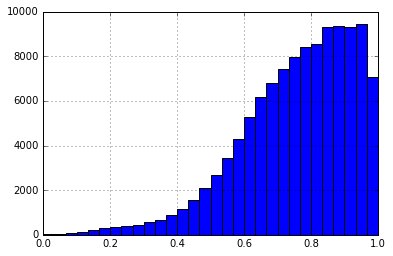

In [18]:
%matplotlib inline

import matplotlib
submission.PredictedProb.hist(bins=30)